### aim: 

### date: 

In [9]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [10]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [11]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')
#list of models
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS')
import lom
import utils as ut

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

In [12]:
regs = ['ARCTIC', 'P1', 'P2', 'P3', 'P4', 'P5', 'A1', 'A2', 'A3', 'A4', 'A5', 'I3', 'I4', 'I5']

regdict = {'ARCTIC' : {'number' : 0.5},
           'P1' : {'number': 1.0},
          'P2' : {'number': 1.2},
           'P3' : {'number': 1.4},
           'P4' : {'number': 1.6},
           'P5' : {'number': 1.8},
            'A1' : {'number': 2.4},
          'A2' : {'number': 2.6},
           'A3' : {'number': 2.8},
           'A4' : {'number': 3},
           'A5' : {'number': 3.2},
           'I3' : {'number': 3.6},
           'I4' : {'number': 3.8},
           'I5' : {'number': 4},
           
          }
    
tics = []
tcm = 'Spectral'
tmask = nc.Dataset('/gpfs/data/greenocean/software/resources/breakdown/clq_basin_masks_ORCA.nc')

maskno = np.zeros([149,182])
for i in range(0, len(regs)):
    maskno[tmask[regs[i]][:] == 1] = regdict[regs[i]]['number']
    tics.append(regdict[regs[i]]['number'])
maskno[maskno == 0] = np.nan

mask_latbands = np.copy(maskno)

mask_latbands[maskno == 0.5] = 1
mask_latbands[(maskno == 1) | (maskno == 2.4)] = 2
mask_latbands[(maskno == 1.2) | (maskno == 2.6)] = 3
mask_latbands[(maskno == 1.4) | (maskno == 2.8) | (maskno == 3.6)] = 4
mask_latbands[(maskno == 1.6) | (maskno == 3.0) | (maskno == 3.8)] = 5
mask_latbands[(maskno == 1.8) | (maskno == 3.2) | (maskno == 4.0)] = 6

#####
tmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
tmesh['csize'] = tmesh.tmask[0,0,:,:] * tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:]

csize_broad = np.zeros([31,149,182])
for i in range(0,31):
    csize_broad[i,:,:] = tmesh['csize'].values
cvol = csize_broad * tmesh['e3t_0'][0,:,:,:] * tmesh['tmask'][0,:,:,:]

cdepth = tmesh['e3t_0'][0,:,:,:] * tmesh['tmask'][0,:,:,:]
cdepth_broad = np.zeros([12,31,149,182])
for i in range(0,12):
    cdepth_broad[i,:,:,:] = cdepth
    
def make_yearlist(yrst, yrend, dtype, tr, baseDir = '/gpfs/afm/greenocean/software/runs'):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        ty = f'{baseDir}/{tr}/ORCA2_1m_{yrs[i]}*{dtype}*.nc'
        t2 = glob.glob(ty)
        #print(t2)
        ylist.append(t2[0])
    return ylist

def gimme_var(ds, var):
    '''
    takes ds of type grid, calculates seasonal by-lat 1-d tracers (tos, sos, lmdr10_1.
    '''
    seas_lat_var = np.zeros([12,6]) #storage array
    #print(ds[plant].long_name)
    tmn = ds[var] #.groupby('time_counter.season').mean('time_counter') #get seasonal mean1
    tmesh['csize'] = tmesh.tmask[0,0,:,:] #* tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:]
    tmn_molm2 = tmn*tmesh.csize #just 0,1
    #tmn_molm2 = np.nansum(tmn_test, axis = 1) #integrate, ie sum

    for s in range(0,12):        
        for b in range(0,6):
            tmn_molm2_formask = np.copy(tmn_molm2) #copy for manipulations
            tmn_molm2_formask_tseas = tmn_molm2_formask[s,:,:] # 
            tmn_molm2_formask_tseas[mask_latbands != b+1] = 0
            csize_formask = np.copy(csize_broad[0,:,:])
            csize_formask[mask_latbands != b+1] = 0
            seas_lat_var[s,b] = np.ma.average(tmn_molm2_formask_tseas[:,:], weights=csize_formask)

    return seas_lat_var

In [13]:
def make_tracer_seas_lat_gridT(yrst, tr, baseDir = '/gpfs/afm/greenocean/software/runs/'):
    
    tdir = '/gpfs/home/mep22dku/scratch/SOZONE/ecosystemLooks/mld-and-friends/'
    tnam1 = f'{tr}-gridT-{yrst}.nc'
    tnam = f'{tdir}{tr}-gridT-{yrst}.nc'
    print(tnam1)
    
    dtype = 'grid_T'
    #baseDir = '/gpfs/afm/greenocean/software/runs/'
    yrend = yrst #
    ylist = make_yearlist(yrst, yrend, dtype, tr, baseDir)
    ds = xr.open_dataset(ylist[0])
    
    times = pd.date_range(f"{yrst}/01/01",f"{yrst+1}/01/01",freq='MS',closed='left')

    seas_lat_tos = gimme_var(ds, 'tos')
    seas_lat_sos = gimme_var(ds, 'sos')
    seas_lat_mldr10_1 = gimme_var(ds, 'mldr10_1')
    
    data_vars = {
#                     'Alkalini':(['time_counter',  'lat_band'], seas_lat_Alkalini,
#                  {'units': 'mol/m2'}),
                     
                 'sos':(['time_counter',  'lat_band'], seas_lat_sos,
                 {'units': 'g/kg'}),
                 'tos':(['time_counter',  'lat_band'], seas_lat_tos,
                 {'units': 'degC'}),
                 'mldr10_1':(['time_counter',  'lat_band'], seas_lat_mldr10_1,
                 {'units': 'm'}),        

                }

    # define coordinates
    coords = {'time_counter': (['time_counter'], times),\
             'lat_band': (['lat_band'], np.arange(1,7,1)),}

    # define global attributes
    attrs = {'made in':'SOZONE/ecosystemLooks/fxlgroups-intime.ipynb',
             'latitude bands': 'see notebook, 1 is arctic, 6 is SO',
            }
    
#     # create dataset
    ds2 = xr.Dataset(data_vars=data_vars,
                    coords=coords,
                    attrs=attrs)
    
    ds2.to_netcdf(f'{tnam}')
    


## extract mld temp etc

In [14]:
extract = False
if extract:
    
    for i in range(1950,2100):
        make_tracer_seas_lat_gridT(i, 'TOM12_TJ_1ASA')
        make_tracer_seas_lat_gridT(i, 'TOM12_TJ_1BSA')
        make_tracer_seas_lat_gridT(i, 'TOM12_TJ_1AA6')
        make_tracer_seas_lat_gridT(i, 'TOM12_TJ_1BA6')

    for i in range(1950,2023):
        make_tracer_seas_lat_gridT(i, 'TOM12_TJ_RVA0')
        make_tracer_seas_lat_gridT(i, 'TOM12_ET_SI73', baseDir = '/gpfs/home/e031/scratch/')

In [15]:
def make_yearlist(yrst, yrend, tr):
    baseDir = '/gpfs/home/mep22dku/scratch/SOZONE/ecosystemLooks/mld-and-friends'
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        ty = f'{baseDir}/{tr}-gridT-{yrs[i]}.nc'
        t2 = glob.glob(ty)
        #print(t2)
        ylist.append(t2[0])
    return ylist

ET_SI73 = xr.open_mfdataset(make_yearlist(1950, 2019, 'TOM12_ET_SI73'))
TJ_RVA0 = xr.open_mfdataset(make_yearlist(1950, 2019, 'TOM12_TJ_RVA0'))
TJ_1ASA = xr.open_mfdataset(make_yearlist(1950, 2019, 'TOM12_TJ_1ASA'))
TJ_1AA6 = xr.open_mfdataset(make_yearlist(1950, 2019, 'TOM12_TJ_1AA6'))

0
1
2
3


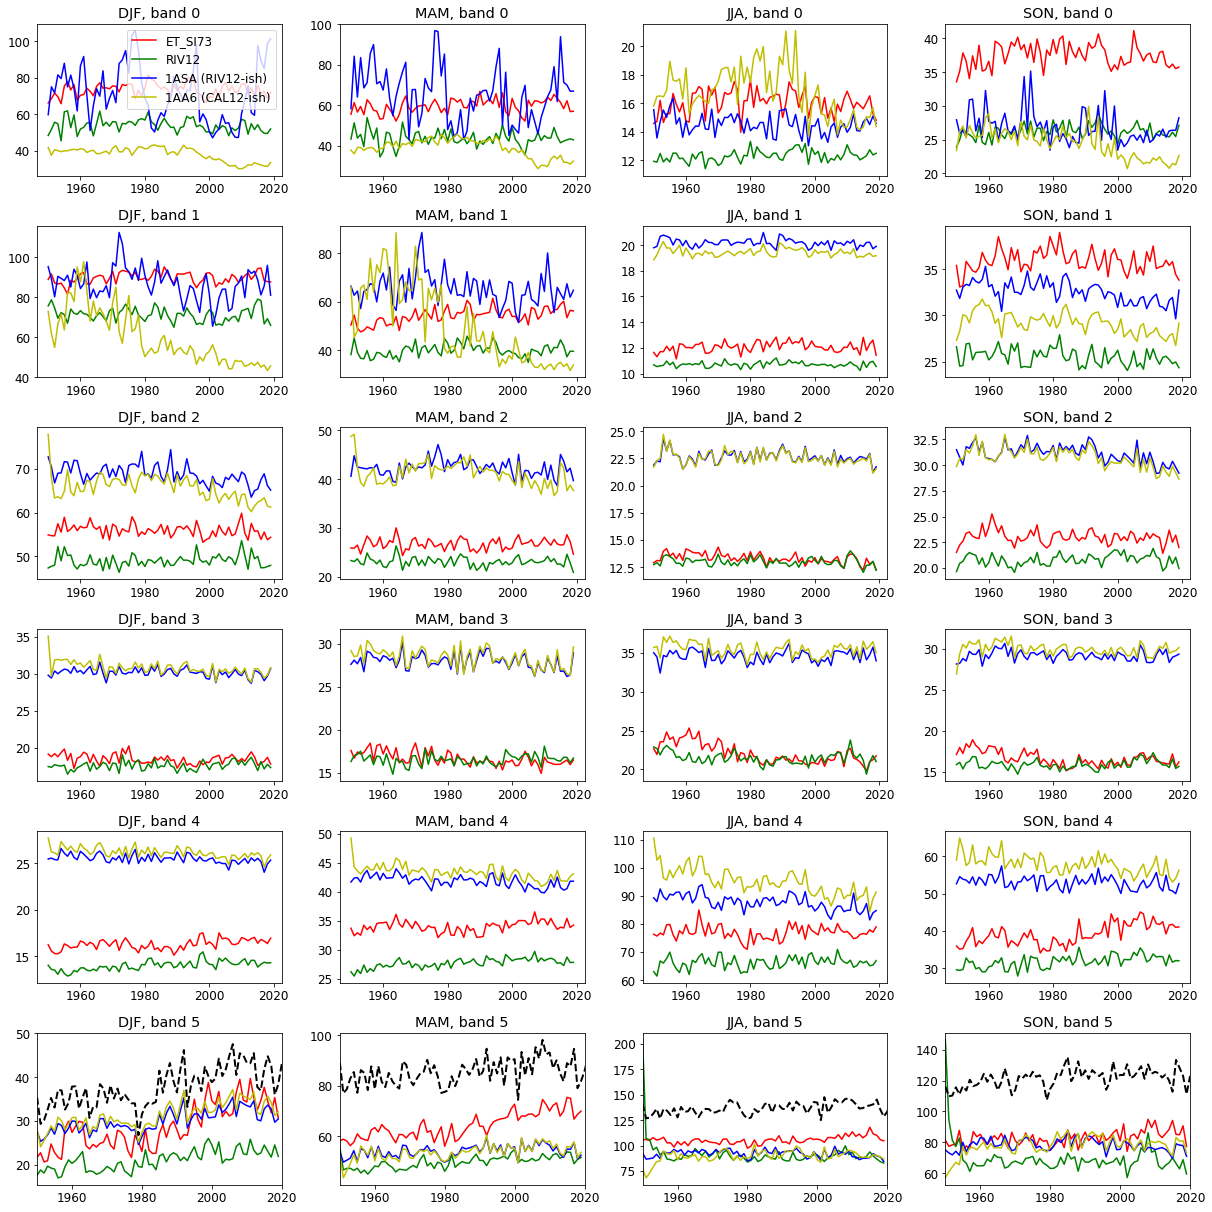

In [31]:
ds_ar = [ET_SI73, TJ_RVA0, TJ_1ASA, TJ_1AA6]
labs = ['ET_SI73', 'RIV12', '1ASA (RIV12-ish)', '1AA6 (CAL12-ish)' ]
cols = ['r','g','b','y']

tvar = 'mldr10_1'
fact = 1
fig, axs = plt.subplots(6,4, figsize=(17*fact, 17*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

ds = ds_ar[0]

tseas = ['DJF','MAM','JJA','SON']

for d in range(0,4):
    print(d)
    ds = ds_ar[d]
    col = cols[d]
    lab = labs[d]
    for s in range(0,4):
        for i in range(0,6):
            tdat = ds[tvar].sel(time_counter=(ds['time_counter.season'] == tseas[s])).\
            groupby('time_counter.year').mean()
            ind = i*4+s
            axs[ind].plot(tdat.year,tdat[:,i], color = col, label = lab)
            axs[ind].set_title(f'{tseas[s]}, band {i}')
            
#
for i in range(0,4):
    tmod = xr.open_dataset(f'/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/oceanFields/extracted-summary/somxl010_ukesm_1A.nc')

    tpl = tmod.sel(time_counter=(tmod['time_counter.season'] == tseas[i]))
    tv = tpl.groupby('time_counter.year').mean()
    axs[i+20].plot(tv.year,tv.somxl010, color = 'k',\
                linestyle = '--', linewidth = 2, label = 'UKESM') 
    axs[i+20].set_xlim([1950,2020])        
            
            
axs[0].legend(loc = 'best')
plt.tight_layout()      
        

0
1
2
3


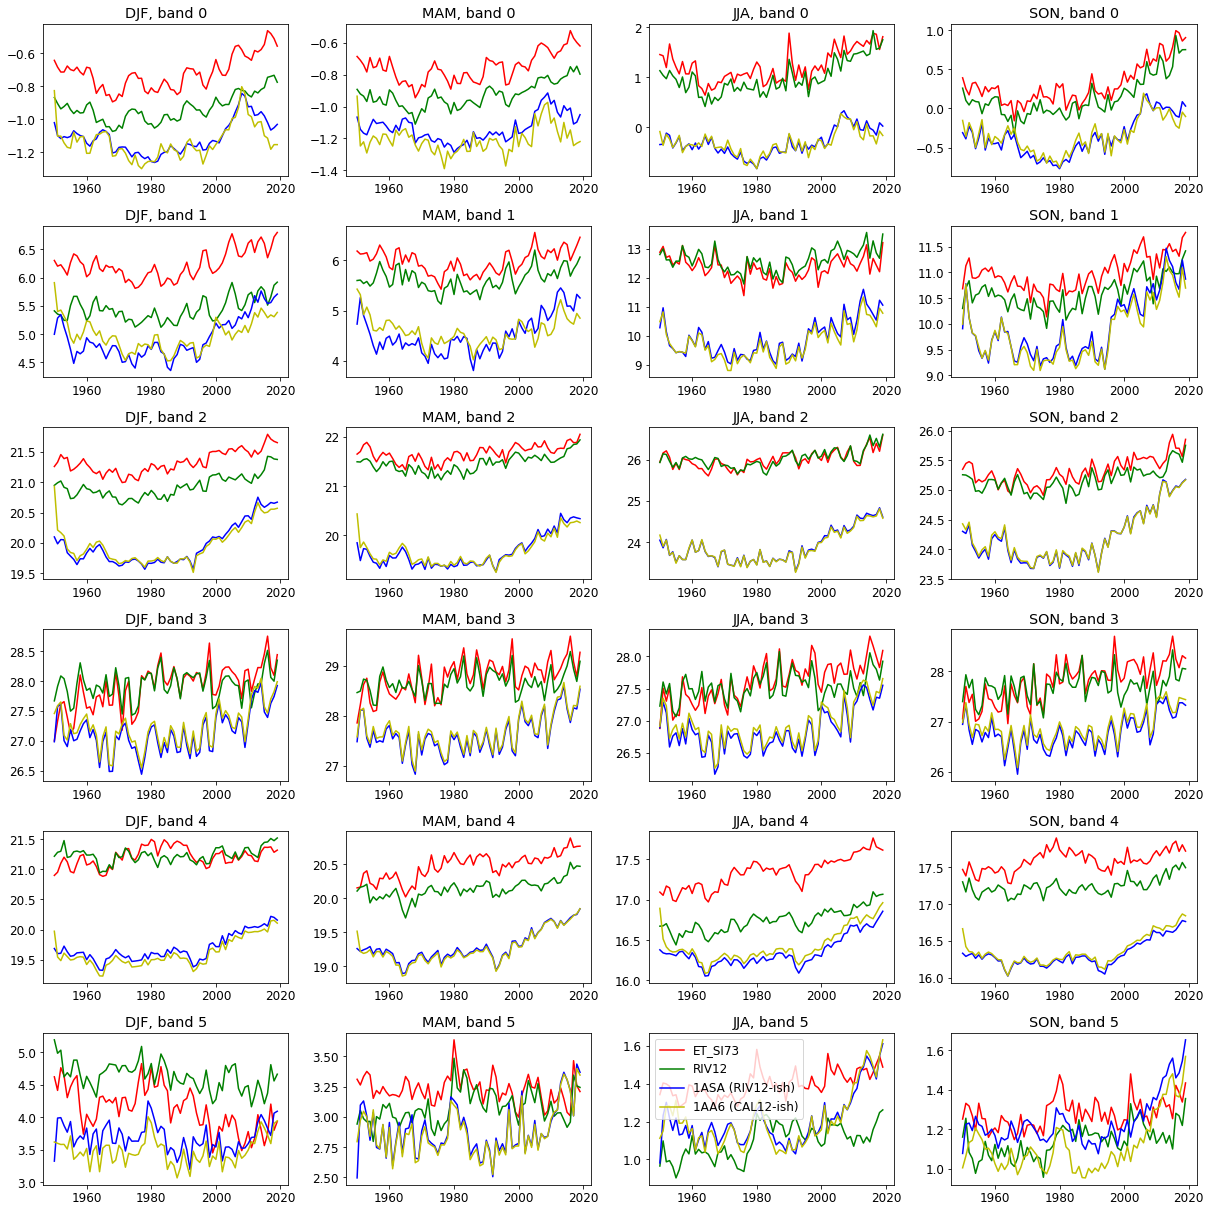

In [30]:
ds_ar = [ET_SI73, TJ_RVA0, TJ_1ASA, TJ_1AA6]
labs = ['ET_SI73', 'RIV12', '1ASA (RIV12-ish)', '1AA6 (CAL12-ish)' ]
cols = ['r','g','b','y']

tvar = 'tos'
fact = 1
fig, axs = plt.subplots(6,4, figsize=(17*fact, 17*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

ds = ds_ar[0]

tseas = ['DJF','MAM','JJA','SON']

for d in range(0,4):
    print(d)
    ds = ds_ar[d]
    col = cols[d]
    lab = labs[d]
    for s in range(0,4):
        for i in range(0,6):
            tdat = ds[tvar].sel(time_counter=(ds['time_counter.season'] == tseas[s])).\
            groupby('time_counter.year').mean()
            ind = i*4+s
            axs[ind].plot(tdat.year,tdat[:,i], color = col, label = lab)
            axs[ind].set_title(f'{tseas[s]}, band {i}')
            
# #
# for i in range(0,4):
#     tmod = xr.open_dataset(f'/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/oceanFields/extracted-summary/somxl010_ukesm_1A.nc')

#     tpl = tmod.sel(time_counter=(tmod['time_counter.season'] == tseas[i]))
#     tv = tpl.groupby('time_counter.year').mean()
#     axs[i+20].plot(tv.year,tv.somxl010, color = 'k',\
#                 linestyle = '--', linewidth = 2, label = 'UKESM') 
#     axs[i+20].set_xlim([1950,2020])        
            
            
axs[0].legend(loc = 'best')
plt.tight_layout()      
        

0
1
2
3


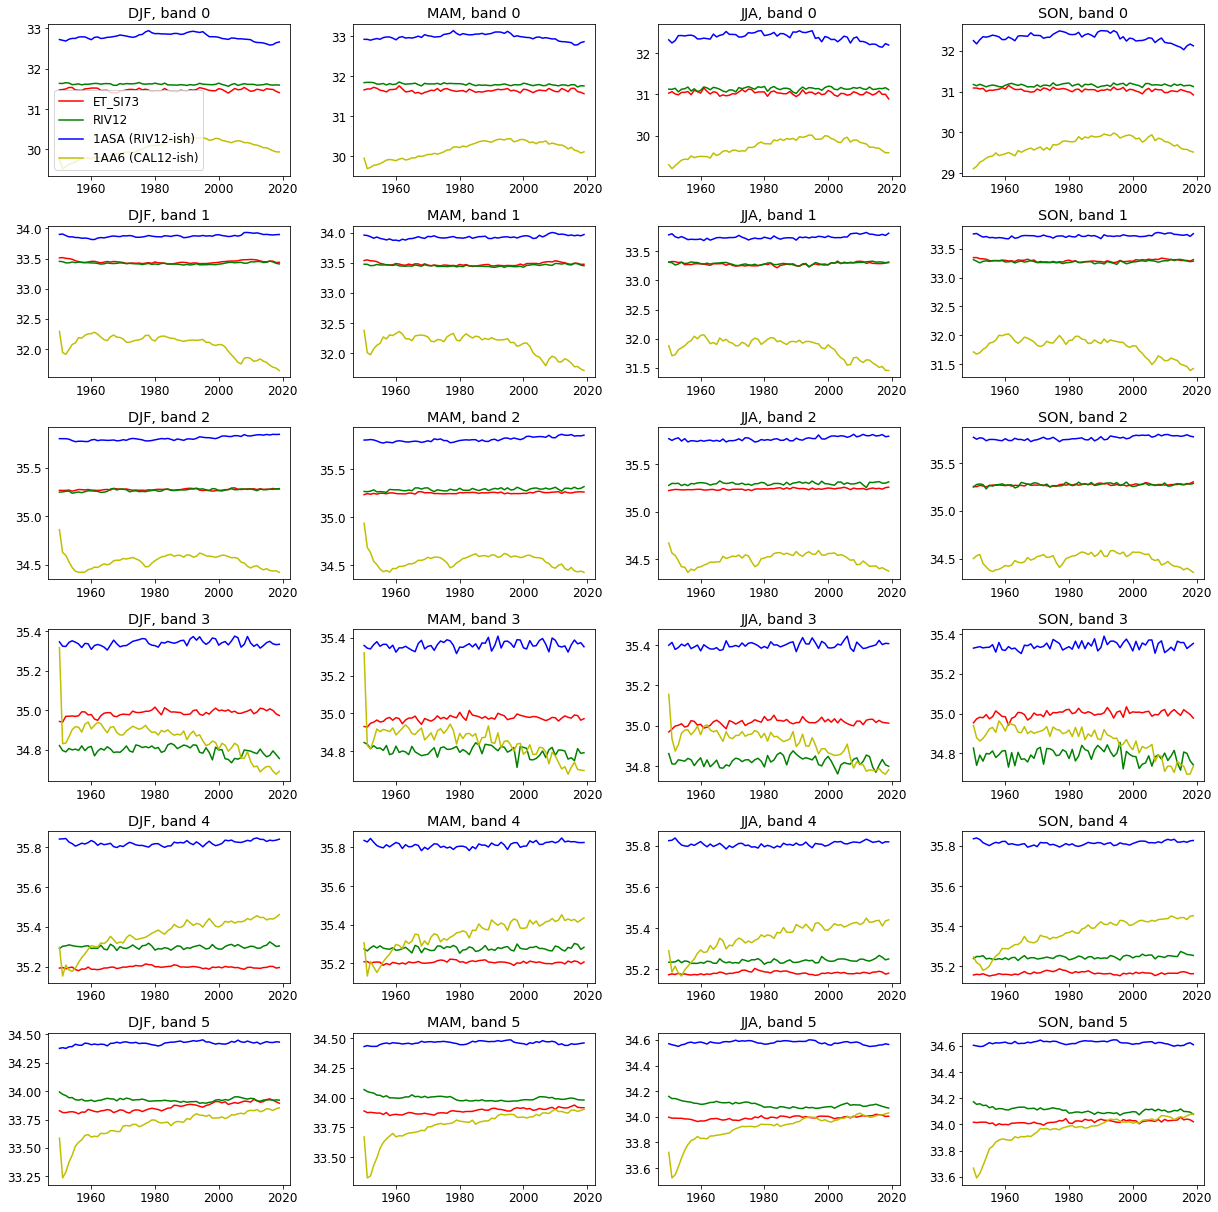

In [32]:
ds_ar = [ET_SI73, TJ_RVA0, TJ_1ASA, TJ_1AA6]
labs = ['ET_SI73', 'RIV12', '1ASA (RIV12-ish)', '1AA6 (CAL12-ish)' ]
cols = ['r','g','b','y']

tvar = 'sos'
fact = 1
fig, axs = plt.subplots(6,4, figsize=(17*fact, 17*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

ds = ds_ar[0]

tseas = ['DJF','MAM','JJA','SON']

for d in range(0,4):
    print(d)
    ds = ds_ar[d]
    col = cols[d]
    lab = labs[d]
    for s in range(0,4):
        for i in range(0,6):
            tdat = ds[tvar].sel(time_counter=(ds['time_counter.season'] == tseas[s])).\
            groupby('time_counter.year').mean()
            ind = i*4+s
            axs[ind].plot(tdat.year,tdat[:,i], color = col, label = lab)
            axs[ind].set_title(f'{tseas[s]}, band {i}')
            
# #
# for i in range(0,4):
#     tmod = xr.open_dataset(f'/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/oceanFields/extracted-summary/somxl010_ukesm_1A.nc')

#     tpl = tmod.sel(time_counter=(tmod['time_counter.season'] == tseas[i]))
#     tv = tpl.groupby('time_counter.year').mean()
#     axs[i+20].plot(tv.year,tv.somxl010, color = 'k',\
#                 linestyle = '--', linewidth = 2, label = 'UKESM') 
#     axs[i+20].set_xlim([1950,2020])        
            
            
axs[0].legend(loc = 'best')
plt.tight_layout()      
        

In [ ]:
ds = make_tracer_seas_lat_gridT(1950, 'TOM12_TJ_1AA6', baseDir = '/gpfs/afm/greenocean/software/runs/')

In [ ]:
# ds.tos
# ds.sos
# ds.mldr10_1


def gimme_plant(ds, var):
    '''
    takes ds of type grid, calculates seasonal by-lat 1-d tracers (tos, sos, lmdr10_1.
    '''
    seas_lat_var = np.zeros([12,6]) #storage array
    #print(ds[plant].long_name)
    tmn = ds[var] #.groupby('time_counter.season').mean('time_counter') #get seasonal mean1
    tmesh['csize'] = tmesh.tmask[0,0,:,:] #* tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:]
    tmn_molm2 = tmn*tmesh.csize #just 0,1
    #tmn_molm2 = np.nansum(tmn_test, axis = 1) #integrate, ie sum

    for s in range(0,12):        
        for b in range(0,6):
            tmn_molm2_formask = np.copy(tmn_molm2) #copy for manipulations
            tmn_molm2_formask_tseas = tmn_molm2_formask[s,:,:] # 
            tmn_molm2_formask_tseas[mask_latbands != b+1] = 0
            csize_formask = np.copy(csize_broad[0,:,:])
            csize_formask[mask_latbands != b+1] = 0
            seas_lat_var[s,b] = np.ma.average(tmn_molm2_formask_tseas[:,:], weights=csize_formask)

    return seas_lat_var

seas_lat_var = gimme_plant(ds,'mldr10_1')

In [ ]:
print(seas_lat_var[:,1])

In [36]:
w = xr.open_dataset('/gpfs/data/greenocean/software/resources/MEDUSA/oneyear2009ukesm/nemo_bc370o_1m_20090301-20090401_grid-T.nc')

w.somxl010


<xarray.DataArray 'somxl010' (time_counter: 1, y: 332, x: 362)>
[120184 values with dtype=float32]
Coordinates:
    nav_lat        (y, x) float32 ...
    nav_lon        (y, x) float32 ...
    time_centered  (time_counter) object ...
  * time_counter   (time_counter) float64 0.0
Dimensions without coordinates: y, x
Attributes:
    standard_name:       ocean_mixed_layer_thickness_defined_by_sigma_theta
    long_name:           Mixed Layer Depth (dsigma = 0.01 wrt 10m)
    units:               m
    online_operation:    average
    interval_operation:  2700 s
    interval_write:      1 month
    cell_methods:        time: mean (interval: 2700 s)
    cell_measures:       area: area